In [2]:
import pandas as pd

epcpath = 'https://media.githubusercontent.com/media/LondonEnergyMap/cleandata/master/epc/nondomestic/epcldn.csv'

# read csv into dataframe
dfepc = pd.read_csv(epcpath)
dfepc = dfepc.drop(dfepc.columns[0], axis=1)
dfepc.head()

,Unnamed: 0,key,add1,add2,add3,pcode,bref,assetr,assetr_band,prop_type,...,co2_building,ac,ac_kw,ac_estimate,ac_insp,modes,addfull,localauth,constit,certificate
0,1032,1813220100330090318,NaN,61 St. Mary Axe,NaN,EC3A 8AA,397675180000,120,E,Office,...,92.92,No,NaN,NaN,4,Air Conditioning,61 St. Mary Axe,City of London,Cities of London and Westminster,b05beea2eb7f3ef5e9781ff549c35a0e37fd69d21129d6...
1,143,32849020100401040448,NaN,Hawes & Curtis,27 Eastcheap,EC3M 1DE,522872740000,168,G,Office,...,249.59,No,NaN,NaN,4,Heating and Natural Ventilation,"Hawes & Curtis, 27 Eastcheap",City of London,Cities of London and Westminster,8bec6662846db9514af48d5fa250d9b83825c68778eaad...
2,1842,32834520100401030441,NaN,Caffe Nero,23 Eastcheap,EC3M 1DE,278860250000,161,G,Office,...,295.18,No,NaN,NaN,4,Air Conditioning,"Caffe Nero, 23 Eastcheap",City of London,Cities of London and Westminster,dda240f7b4f24e0b1c9ecbf0f8cfe1062ae4ae8a526d87...
3,1443,56929120111123051103,NaN,2-5 Minories,NaN,EC3N 1BJ,982231410000,125,E,B1 Offices and Workshop businesses,...,88.99,No,NaN,NaN,4,Air Conditioning,2-5 Minories,City of London,Cities of London and Westminster,172bd964e01e465fefed7cfe6bc739d483fdfeb1ca8faf...
4,930,49297720110415030438,7TH FLOOR,Chancery House,53-64 Chancery Lane,WC2A 1QS,123945260004,153,G,B1 Offices and Workshop businesses,...,96.94,Yes,NaN,3.0,5,Air Conditioning,"7TH FLOOR, Chancery House, 53-64 Chancery Lane",City of London,Cities of London and Westminster,51efa4b414c56c7a1ca95318ba390a021cc9735060475e...


In [6]:
gasfile = 'http://media.githubusercontent.com/media/LondonEnergyMap/cleandata/master/consumption/gascons_pcodeldn.csv'
elecfile = 'http://media.githubusercontent.com/media/LondonEnergyMap/cleandata/master/consumption/eleccons_pcodeldn.csv'

dfgas = pd.read_csv(gasfile)
dfgas.columns = ['pcgas', 'gascons', 'gasmeters', 'gasavg', 'gasmid']

dfelec = pd.read_csv(elecfile)
dfelec.columns = ['pcelec', 'eleccons', 'elecmeters', 'elecavg', 'elecmid']


def merge_pcode(dfepc, dfpc, match):

    # merge entries with exact postcode match
    df = dfepc.merge(
        dfpc, how='inner', left_on=['pcode'], right_on=dfpc.columns[0])

    # add column to indicate the entries are exact postcode matches
    df[match] = 'exact'

    # match the remaining entries that did not have exact postcode matches to
    # partial match
    dfremain = dfepc.copy()
    dfremain = dfremain[(~dfremain.pcode.isin(df.pcode))]

    # split the postcode into 2 parts and match only first part
    pc = dfremain.pcode.str.split(' ', n=1, expand=True)
    dfremain['pc1'] = pc[0]
    dfremain['pc2'] = pc[1]

    # drop postcode entries that do not have full postcodes
    pctemp = dfpc.columns[0]
    dfpcshort = dfpc[dfpc[pctemp].str.len() <= 3]

    # merge the remaining epc dataframe with partial postcodes
    dftemp = dfremain.merge(
        dfpcshort, how='inner', left_on=['pc1'], right_on=dfpcshort.columns[0])

    # add column to indicate the entries will be partial matches
    dftemp[match] = 'partial'

    # append the partical postcode match to full postcode match dataframe after
    # dropping additional columns
    dftemp = dftemp.drop(columns=['pc1', 'pc2'])
    df = df.append(dftemp)

    # add tag to the leftover entries that do not match any postcodes and
    # append back to main dataframe
    dfleftover = dfepc.copy()
    dfleftover = dfleftover[(~dfleftover.pcode.isin(df.pcode))]

    # fill empty columns with Nan in order to append to main dataframe
    for i in range(len(dfpc.columns)):
        dfleftover[dfpc.columns[i]] = 'Nan'

    dfleftover[match] = 'nomatch'
    df = df.append(dfleftover)

    # drop the repeated postcode column
    df = df.drop(dfpc.columns[0], axis=1)

    return df


# merge postcode gas consumptions to epc dataframe
df = merge_pcode(dfepc, dfgas, 'gasmatch')

# merge postcode electricity consumption to previous dataframe
df = merge_pcode(df, dfelec, 'elecmatch')

In [25]:
df.head()

,Unnamed: 0,key,add1,add2,add3,pcode,bref,assetr,assetr_band,prop_type,...,gascons,gasmeters,gasavg,gasmid,gasmatch,eleccons,elecmeters,elecavg,elecmid,elecmatch
0,1839,32426220100316030331,NaN,6-7 Ludgate Square,NaN,EC4M 7AS,270765180000,118,E,Office,...,72690.4,8.0,9086.3,9693.37,exact,151187,26.0,5814.89,4138.65,exact
1,830,95097120140906040921,NaN,"1, Ludgate Square",NaN,EC4M 7AS,159247150000,76,D,A1/A2 Retail and Financial/Professional services,...,72690.4,8.0,9086.3,9693.37,exact,151187,26.0,5814.89,4138.65,exact
2,1780,108370020160104100149,NaN,8 Ludgate Square,NaN,EC4M 7AS,946369280000,159,G,A1/A2 Retail and Financial/Professional services,...,72690.4,8.0,9086.3,9693.37,exact,151187,26.0,5814.89,4138.65,exact
3,1366,108362520160104100141,NaN,9 Ludgate Square,NaN,EC4M 7AS,751592610000,103,E,A3/A4/A5 Restaurant and Cafes/Drinking Establi...,...,72690.4,8.0,9086.3,9693.37,exact,151187,26.0,5814.89,4138.65,exact
4,127,35136820100510050500,NaN,56 Carter Lane,NaN,EC4V 5EA,449491320000,82,D,Restaurant/public house,...,233835,9.0,25981.7,13508.4,exact,39010.2,8.0,4876.27,1982.8,exact


In [8]:
df.shape

(65033, 47)

In [9]:
dfepc.shape

(65033, 37)

In [30]:
numcols = ['gascons', 'gasmeters', 'gasavg', 'gasmid', 'eleccons', 'elecmeters', 'elecavg', 'elecmid']

df[numcols] = df[numcols].apply(pd.to_numeric, errors='coerce')

In [37]:
df.gasmeters.describe()

count    56106.000000
mean       161.996614
std        241.209805
min          6.000000
25%         15.000000
50%         31.000000
75%        265.000000
max       1112.000000
Name: gasmeters, dtype: float64

In [38]:
df.elecmeters.describe()

count    54958.00000
mean       478.65803
std        794.20731
min          6.00000
25%         17.00000
50%         41.00000
75%        829.00000
max       5195.00000
Name: elecmeters, dtype: float64

In [44]:
m = 10

temp = df[(df.gasmeters <= m) & (df.elecmeters <= m)]
temp.shape

(2385, 47)

In [40]:
temp.head()

,Unnamed: 0,key,add1,add2,add3,pcode,bref,assetr,assetr_band,prop_type,...,gascons,gasmeters,gasavg,gasmid,gasmatch,eleccons,elecmeters,elecavg,elecmid,elecmatch
436,181,83369020130905020956,NaN,53a East Street,NaN,IG11 8EN,316496980000,78,D,B1 Offices and Workshop businesses,...,41812.067260,6.0,6968.677877,5618.199802,exact,10290.4,6.0,1715.066667,1895.05,exact
672,1930,33234220100406080408,NaN,1297 High Road,NaN,N20 9HX,188591220000,57,C,Retail,...,88446.534653,6.0,14741.089109,13256.930693,exact,16897.0,6.0,2816.166667,2426.65,exact
1374,2057,64540020120510090521,NaN,"757, High Road",NaN,N12 8LD,630409580000,72,C,A1/A2 Retail and Financial/Professional services,...,66897.029703,6.0,11149.504950,8970.792079,exact,14218.3,6.0,2369.716667,2509.85,exact
1380,687,65045620120620060608,NaN,Cheltenham & Gloucester Plc,834 High Road,N12 9RA,627164660000,88,D,A1/A2 Retail and Financial/Professional services,...,71396.039604,6.0,11899.339934,4624.752475,exact,13100.3,6.0,2183.383333,1345.85,exact
1381,518,101105220150623030607,NaN,"832-834, High Road",NaN,N12 9RA,255659710000,90,D,A1/A2 Retail and Financial/Professional services,...,71396.039604,6.0,11899.339934,4624.752475,exact,13100.3,6.0,2183.383333,1345.85,exact


In [41]:
temp.dtypes

Unnamed: 0           int64
key                 object
add1                object
add2                object
add3                object
pcode               object
bref                 int64
assetr               int64
assetr_band         object
prop_type           object
insp_date           object
localauth_code      object
constit_code        object
county              object
lodge_date          object
transact_type       object
newb_benchmark       int64
exb_benchmark        int64
complexity           int64
mainheatingfuel     object
otherfuel          float64
special            float64
renewables         float64
tfa                  int64
co2                float64
co2_target         float64
co2_typical        float64
co2_building       float64
ac                  object
ac_kw              float64
ac_estimate        float64
ac_insp              int64
modes               object
addfull             object
localauth           object
constit             object
certificate         object
g

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt

# sort graph by median by creating new groupby dataframe first

def boxplot_sorted(df, by, column):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values()
#   df2[meds.index].boxplot(rot=90)
  df2[meds.index].boxplot(vert=False)

    


/Users/dora/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


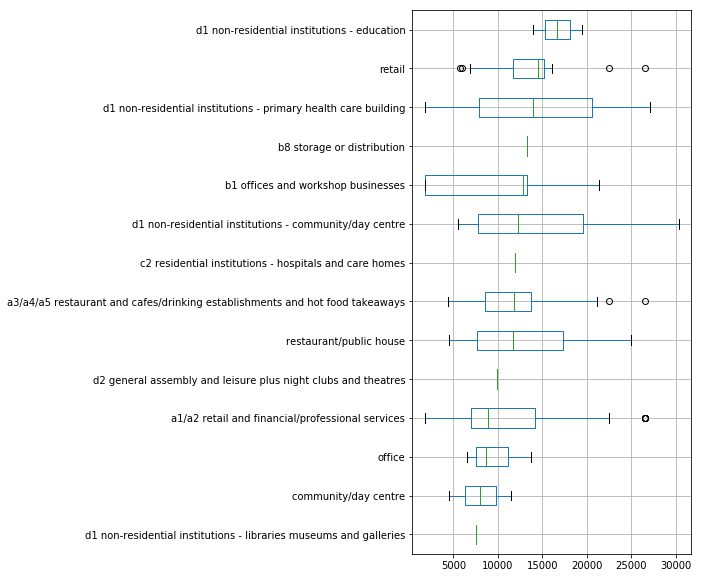

In [43]:
temp['prop_type'] = temp.prop_type.str.lower()

plt.figure(figsize=(5, 10))    
boxplot_sorted(temp, by=['prop_type'], column='gasmid')